In [1]:
import yaml
from agent import AgentController


with open ("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

class CustomArgs:
    def __init__(self, dataset, config):
        for name, value in config[dataset].items():
            setattr(self, name, value)

# experiment = "Split5_CIFAR10"
experiment = "Split5_MNIST"
args = CustomArgs(experiment, config)
approaches = ["baseline", "EWC", "MAS", "SCP",
              "SI", "RWalk", "Neuron", "NeuGrad",
              "GradCAM"]

admin = AgentController(experiment, args)
data_seq = admin.data_seq
train_seq = data_seq["train"]
test_seq = data_seq["test"]
reg_spec_seq = data_seq["reg_spec"]

Loading the Split5_MNIST data_seq: Complete.


In [16]:
from utils import RegularTrain, RawTrain
from copy import deepcopy
import torch
from torch.nn import functional as F
import numpy as np

class ClusterRecorder:
    def __init__(self, test_seq):
        self.test_seq = test_seq
        self.cur_task = 0
        self.cluster = list()
        self.clusterGroups = dict()
        self.models = list()

    def save_neuron(self, func):
        def wrapper(*args):
            model = self.models[0]
            device = next(model.parameters()).device.type

            test_dataloader = self.test_seq[0]
            container = list()
            with torch.no_grad():
                for X, y in test_dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    pred = F.softmax(pred, dim=1)
                    container.append(pred.cpu().numpy())
            self.cluster.append(np.concatenate(container))
            func(*args)
        return wrapper

    def store_data(self):
        self.clusterGroups[self.cur_task] = deepcopy(self.cluster)
        self.cluster.clear()

    def update_task_id(self, task_id):
        self.cur_task = task_id

    def add_model(self, model):
        self.models.append(model)


recorder = ClusterRecorder(test_seq)

class DummyRegTrain(RegularTrain):
    @recorder.save_neuron
    def train(self, model, dataloader,
              optimizer, loss_fn, reg_groups=None):
        size = len(dataloader.sampler)
        
        for batch, (X, y) in enumerate(dataloader):
            loss = self.base_train(model, X, y, optimizer,
                                   loss_fn, reg_groups, batch)
            # Print the information
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

class DummyRawTrain(RawTrain):
    @recorder.save_neuron
    def train(self, model, dataloader,
              optimizer, loss_fn, reg_groups=None):
        size = len(dataloader.sampler)
        
        for batch, (X, y) in enumerate(dataloader):
            loss = self.base_train(model, X, y, optimizer,
                                   loss_fn, reg_groups, batch)
            # Print the information
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [17]:
admin.register_approach("baseline")
agent = getattr(admin, "baseline")
agent.reset()
agent._train = DummyRawTrain().train

tasks = agent.tasks
for task_id in range(tasks):
    recorder.add_model(agent.model)
    agent.run_one_task(train_seq, test_seq,
                       reg_spec_seq, task_id)
    recorder.update_task_id(task_id)
    recorder.store_data()

Initialize the accuracy tracker: Complete.
Initialize the model tracker: Complete.
Generate the shared weights: Complete.
Initialize the MLP2 model: Complete.
Load model from base_models/Split5_MNIST/MLP2.pth: Complete.
Start Task-1:
Epoch 1
-------------------------------
loss: 0.703817  [    0/12665]
loss: 0.445203  [ 6400/12665]
Test Error: 
 Accuracy: 99.76%, Avg loss: 0.090716 

Epoch 2
-------------------------------
loss: 0.119913  [    0/12665]
loss: 0.071640  [ 6400/12665]
Test Error: 
 Accuracy: 99.81%, Avg loss: 0.020090 

Epoch 3
-------------------------------
loss: 0.049300  [    0/12665]
loss: 0.046827  [ 6400/12665]
Test Error: 
 Accuracy: 99.86%, Avg loss: 0.011119 

Epoch 4
-------------------------------
loss: 0.038724  [    0/12665]
loss: 0.038471  [ 6400/12665]
Test Error: 
 Accuracy: 99.86%, Avg loss: 0.007870 

Epoch 5
-------------------------------
loss: 0.033338  [    0/12665]
loss: 0.033287  [ 6400/12665]
Test Error: 
 Accuracy: 99.91%, Avg loss: 0.006206 

E

## Split5_MNIST cluster

In [65]:
from copy import deepcopy

cluster = list()
for task_id in range(tasks):
    cluster += deepcopy(recorder.clusterGroups[task_id])

## Split5_CIFAR10 cluster

In [171]:
import pickle
from copy import deepcopy

filename = "cifarCluster_m1.pkl"
# filename = "cifarCluster_m1(softmax).pkl"
with open(filename, "rb") as f:
    cifar_cluster = pickle.load(f)
cluster = list()
for task_id in range(tasks):
    cluster += deepcopy(cifar_cluster[task_id])

In [162]:
def colormap(experiment):
    args = CustomArgs(experiment, config)
    admin = AgentController(experiment, args)
    data_seq = admin.data_seq
    train_seq = data_seq["train"]
    test_seq = data_seq["test"]
    reg_spec_seq = data_seq["reg_spec"]

    palette = np.array([[255.0, 106.0, 106.0],
                        [60.0, 179.0, 113.0]])
    palette /= 255.0
    container = list()
    for X, y in test_seq[0]:
        container.append(deepcopy(y.numpy()))
    labels = np.concatenate(container)
    colors = palette[labels]
    return colors

In [172]:
# colors = colormap("Split5_MNIST")
colors = colormap("Split5_CIFAR10")

Loading the Split5_CIFAR10 data_seq: Complete.


In [177]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

post_cluster = np.array(cluster)
Figure = plt.figure()
x = post_cluster[0][:,0]
y = post_cluster[0][:,1]
scatter = plt.scatter(x, y, c=colors)
vmax = np.max(post_cluster)+0.2
vmin = np.min(post_cluster)-0.2
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)
plt.grid()
num = len(post_cluster)

def AnimationFunction(frame):
    scatter.set_offsets(post_cluster[frame])

interval = 200
anim_created = FuncAnimation(Figure, AnimationFunction, frames=num, interval=interval)
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [142]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()
lines_plotted = plt.plot([])
line_plotted = lines_plotted[0]
plt.xlim(0, 2*np.pi)
plt.ylim(-1.1, 1.1)
x = np.linspace(0, 2*np.pi, 100)
y = 0

def AnimationFunction(frame):
    y = np.cos(x+2*np.pi*frame/100)
    line_plotted.set_data((x, y))

anim_created = FuncAnimation(Figure, AnimationFunction, frames=100, interval=25)
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

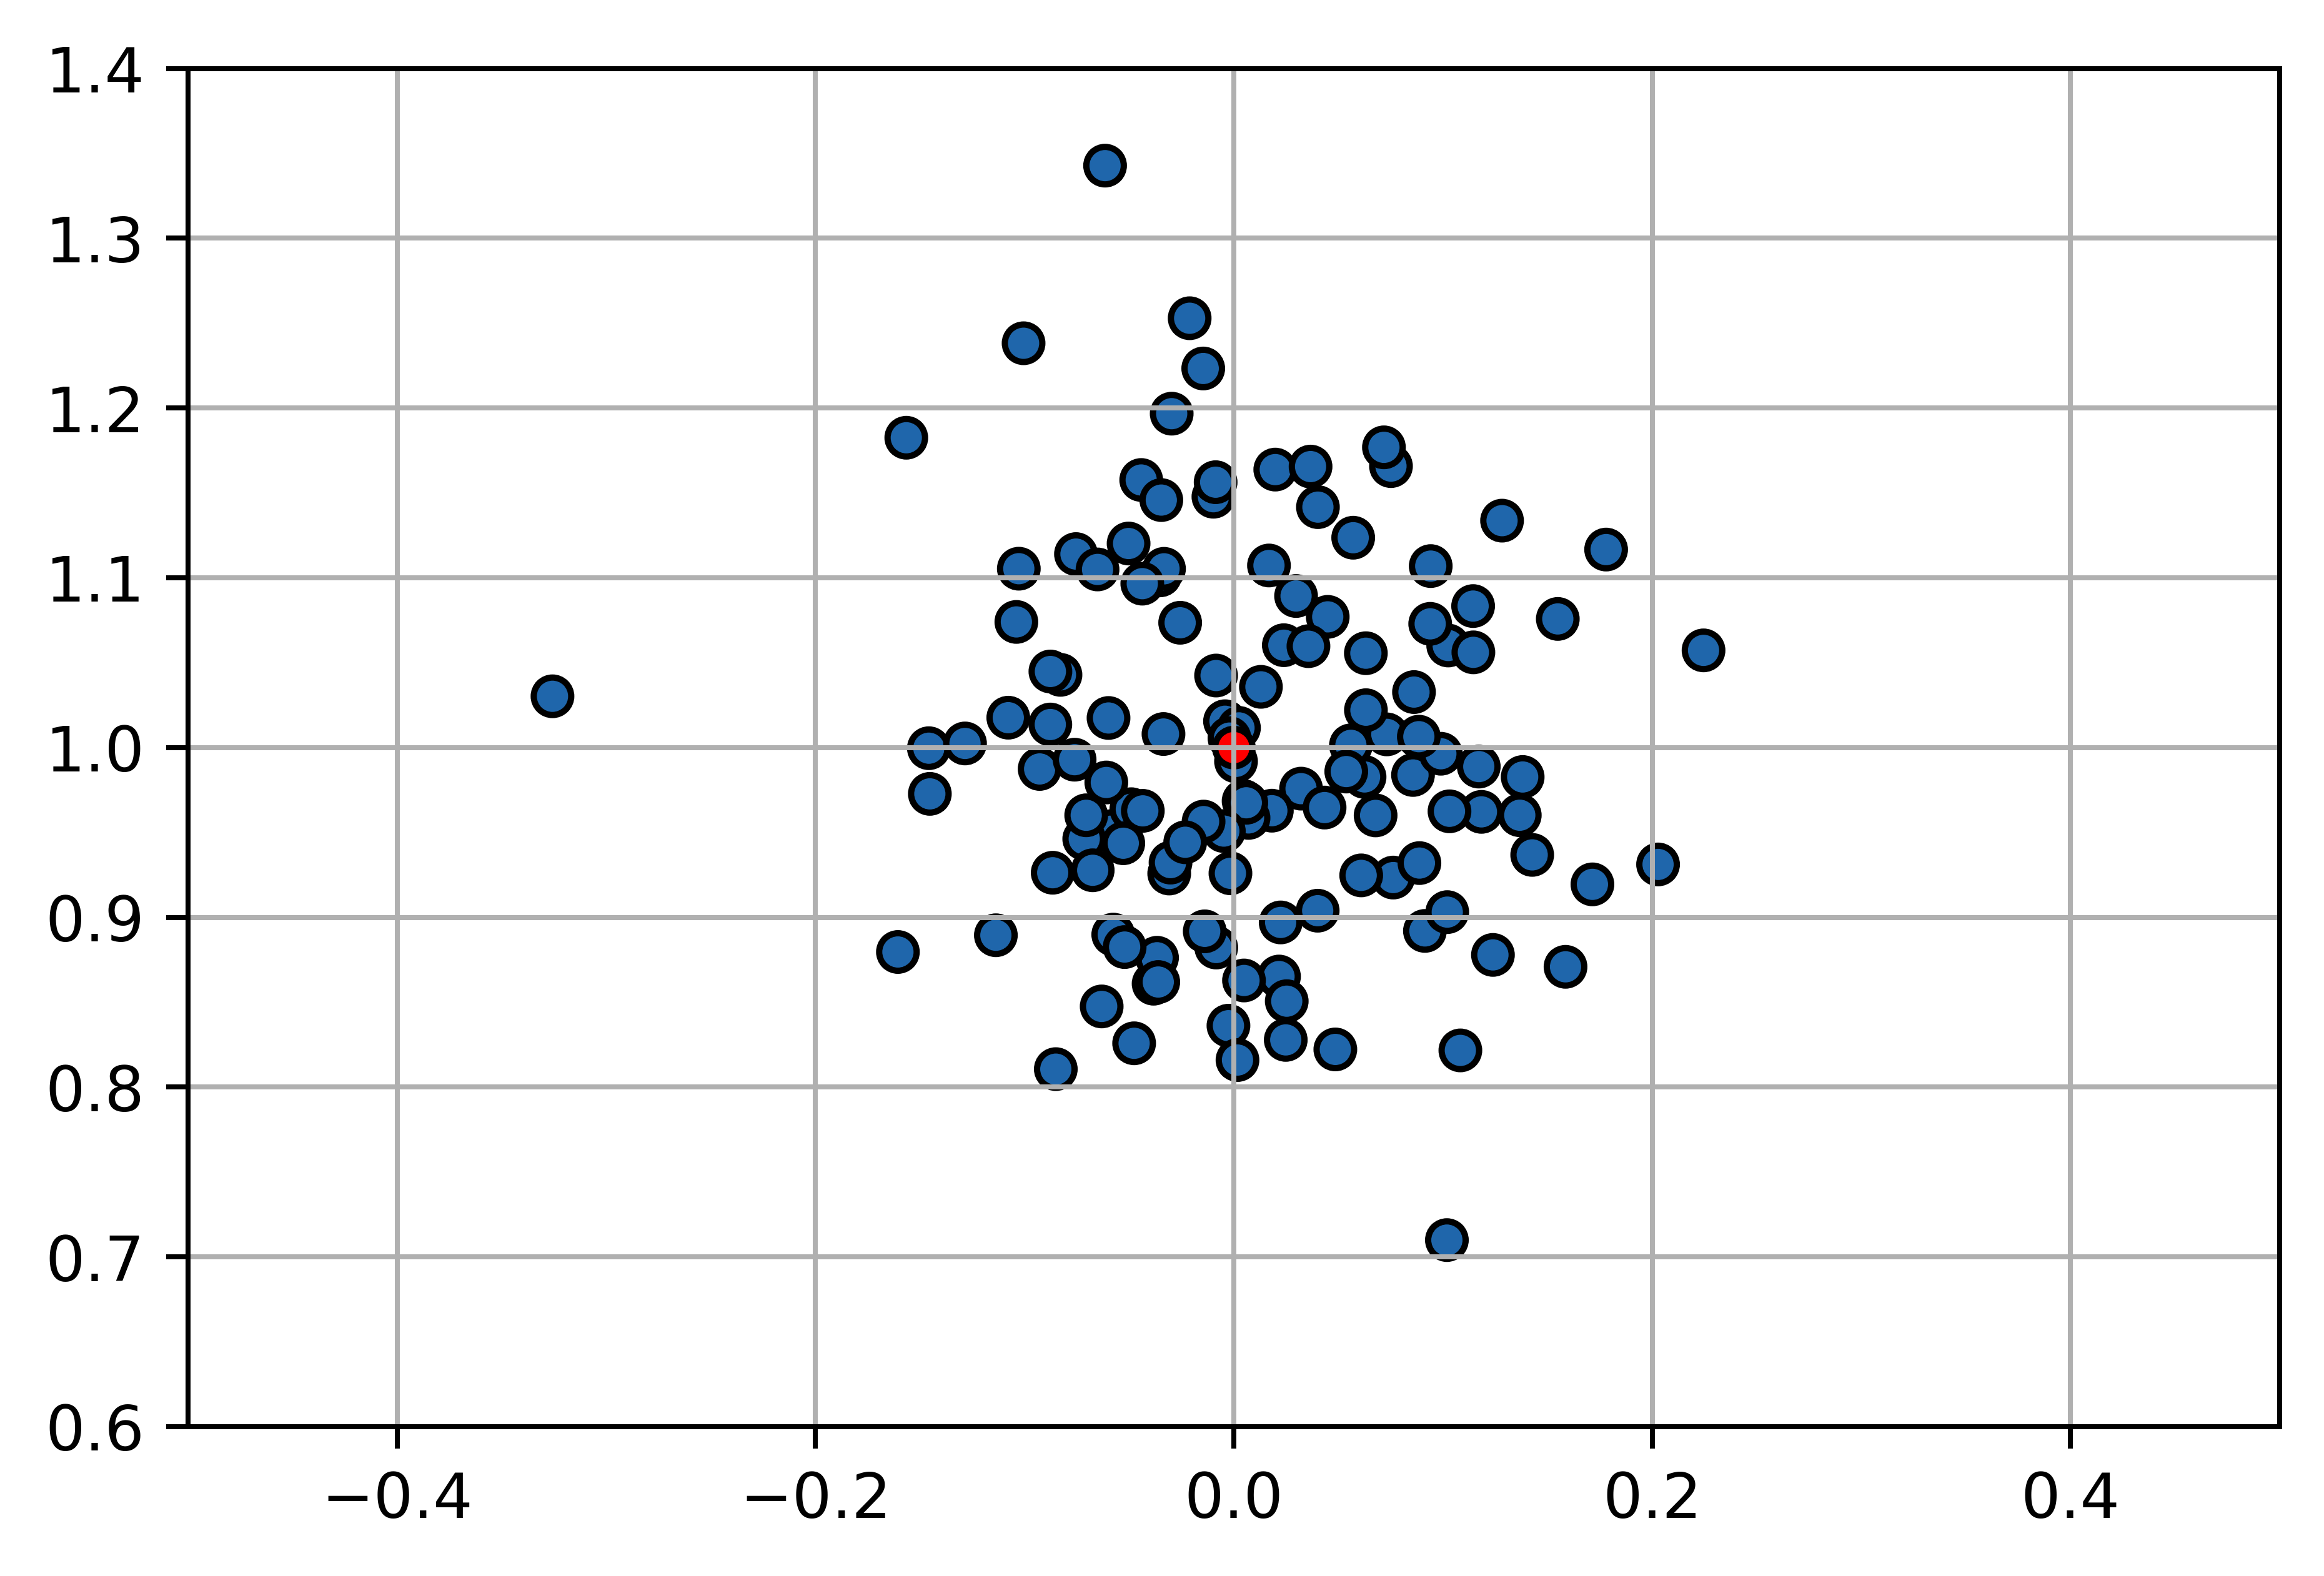

In [75]:
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(dpi=720)
src = np.array([0, 1]).reshape((1,2))
eps = 10e-2
noise = eps*np.random.randn(128, 2)
dst = src+noise
dst[-1] = src
colors = np.zeros((dst.shape[0], 3), dtype=np.float64)
colors[:,] = np.array([0.12, 0.40, 0.67])
colors[-1] = np.array([1, 0, 0])
plt.ylim(0.6, 1.4)
plt.xlim(-0.5, 0.5)
plt.scatter(dst[:,0], dst[:,1], c=colors, edgecolors=[0,0,0])
plt.grid()
plt.show()